In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import altair as alt
from sublimpy import utils
from sublimpy import variables
from sublimpy import tidy

In [2]:
fn = "/Users/elischwat/Downloads/250917_for_Eli/230517_120045.nc"

# Open a subset of one large file

In [3]:
ds = xr.open_dataset(fn, chunks="auto")  # Lazily opens the NetCDF file with Dask

# Get a slice so we just do a bit of processing
ds = ds.sel(frame=slice(0, 10)).compute()


In [4]:
# Let's just use 1 frame
ds_1frame = ds['irdata'].sel(frame=0)

In [5]:
# the data is "shifted" in the col axis.. we need to chop and concatenate. 
# This col value where the shift happens varies with frame...
# we will only deal with one frame for now.
right_side = ds_1frame.sel(col = slice(0,868))
left_side  = ds_1frame.sel(col = slice(869, 1024))
ds_1frame = xr.concat(
    [left_side, right_side],
    dim='col'
)

# Transpoe and then reverse rows so that it plots in a visually-spatially-correct way
ds_1frame = ds_1frame.T
ds_1frame = ds_1frame[::-1,::]

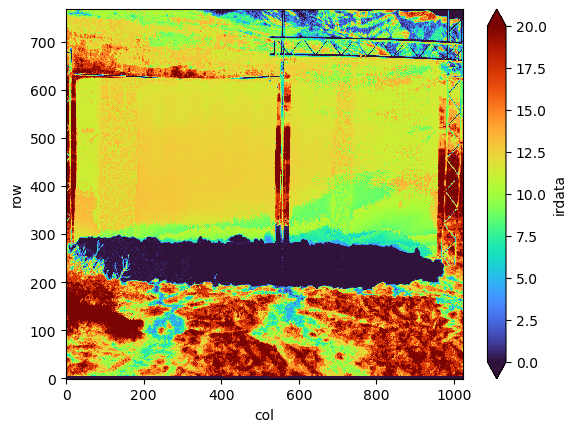

In [6]:
ds_1frame.plot(vmin=0,vmax=20, cmap='turbo')

find the "ground" - where the left pole "ends"

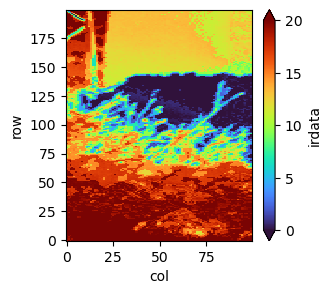

In [7]:
ds_1frame.sel(
    row=slice(150,350),
    col=slice(0, 100),
).plot(vmin=0,vmax=20, cmap='turbo', figsize=(3,3))

Looks like its at about row=125. We will grab all data above that 

In [8]:
ds_1frame_cropped = ds_1frame.sel(row=slice(275,ds_1frame.row.values.max()))

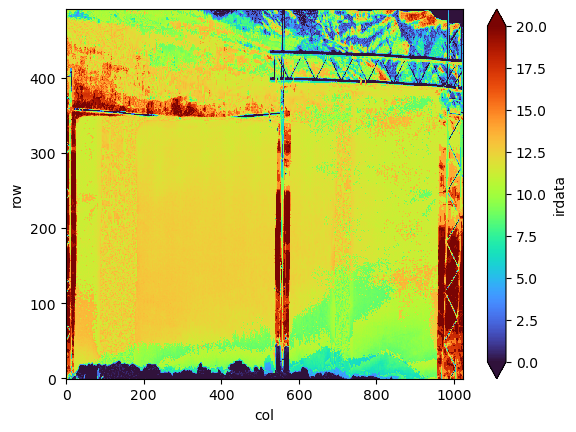

In [9]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Grab a subset of the data so col starts at and ends at the left and right boundaries of the two sheets.

In [10]:
# this removes the left most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(28,1024))

# this removes the right most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(0, 929))

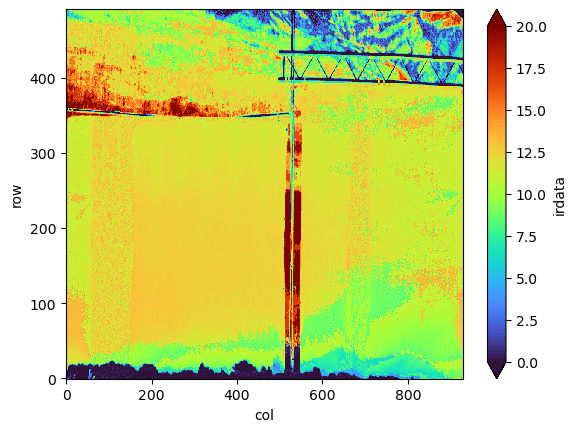

In [11]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Now let's cut off the top

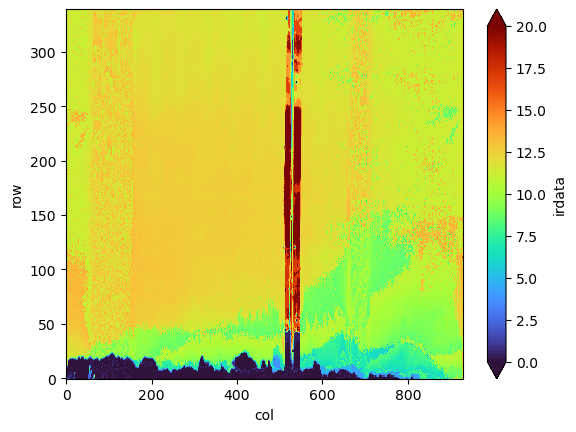

In [12]:
ds_1frame_cropped.sel(
    row = slice(0,340)
).plot(vmin=0,vmax=20, cmap='turbo')

In [13]:
ds_1frame_cropped = ds_1frame_cropped.sel(
    row = slice(0,340)
)

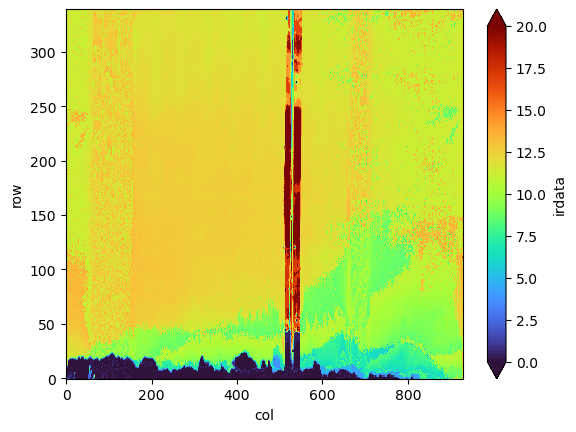

In [14]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Remove the data in between the two sheets

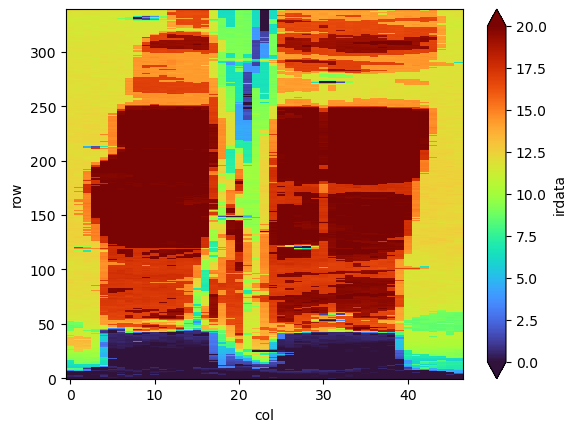

In [15]:
ds_1frame_cropped.sel(
    col = slice(508,555)
).plot(vmin=0,vmax=20, cmap='turbo')

In [16]:
ds_1frame_cropped = ds_1frame_cropped.where(
    (ds_1frame_cropped.col < 508)
    | (ds_1frame_cropped.col > 555)
)

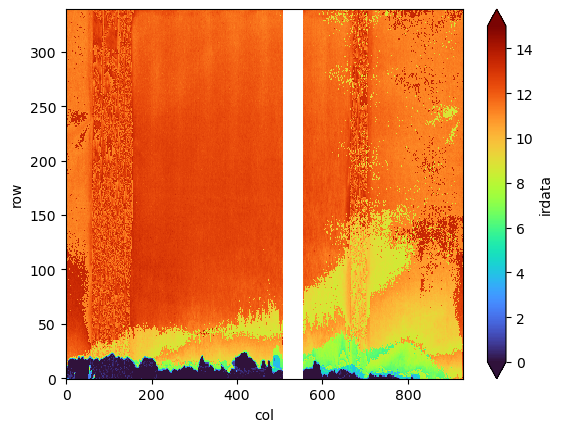

In [17]:
ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo')

Convert the row and column indices to meters

Length relations: 
* the fixation of the left horizontal bar at the leftmost vertical bar is at 1.90m above the (bare) surface. 
* The left horizontal bar from vertical post to vertical post is 2.92m long. 
* The right horizontal bar from vertical post to vertical post is 2.06m. The bottom of the right horizontal bar is 2.26m above bare ground at the middle vertical post. Sorry, a lot of numbers...

i.e...
* total width of the col dimension, i.e. from the left edge of left sheet to right edge of right sheet is: 2.06 + 2.92 = **4.98 meters**
* total height of the row dimension, i.e. from where the pole meets the ground to the top support pole, is **1.9 meters**

In [18]:
TOTAL_WIDTH = 4.98
TOTAL_HEIGHT = 1.9

## FOR THE GRIDDED DATA
# create coords x and why, scaling the col and row dimensions using the dimensions of the observations/sheets
ds_1frame_cropped = ds_1frame_cropped.assign_coords(
    x = TOTAL_WIDTH * ds_1frame_cropped.col / len(ds_1frame_cropped.col),
    z = TOTAL_HEIGHT * ds_1frame_cropped.row / len(ds_1frame_cropped.row)
)

# replace the dims with the physical ones
ds_1frame_cropped = ds_1frame_cropped.to_dataframe().reset_index(drop=True).set_index(['x', 'z']).to_xarray().irdata.T

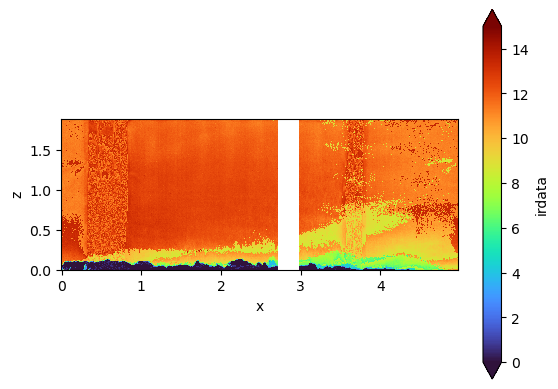

In [119]:
import matplotlib.pyplot as plt
ds_1frame_cropped.plot(vmin=0,vmax=15, cmap='turbo')
plt.gca().set_aspect('equal')

Extract Profiles at 50cm intervals, use 10cm width, 2cm height, bins to get values

In [20]:
# get a dataframe for easy processing
df = ds_1frame_cropped.to_dataframe().reset_index()

# bin the z values
df = df.assign(
    z = pd.cut(df['z'], np.linspace(-0.02,2,102)).apply(
        lambda interval: interval.right
    )
)

Combine the datasets. Also, reindex into a higher resolution so that we can manipulate the data later.

In [21]:
z_high_res = np.linspace(0, 2, num=1001)  # Adjust num for desired resolution
z_high_res

array([0.   , 0.002, 0.004, ..., 1.996, 1.998, 2.   ])

Where should we extract profiles? Let's not go beyond x=4, because the way we had to crop the data makes it so there is no snow at the bottom beyond x=4. What about x=0?

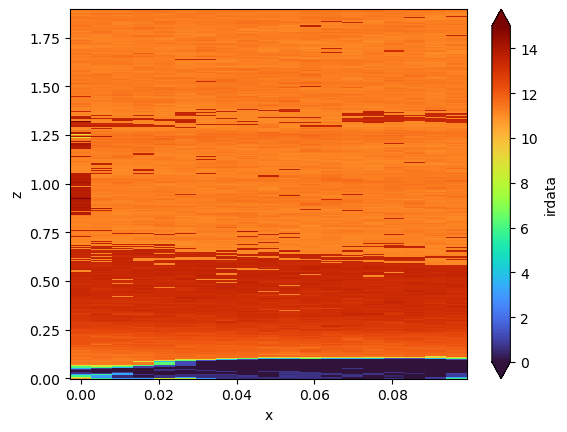

In [22]:
ds_1frame_cropped.sel(x=slice(0,0.10)).plot(vmin=0,vmax=15, cmap='turbo')

We see that data is noisy - let's extract data every 25cm, but make our first data point at 0.01

In [23]:
X = np.linspace(0.5, 4.0, 15)
X

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  ])

In [24]:

df_profiles = pd.DataFrame()
for val in X:
    profile = df.query(
            f"x > {val - 0.05}"
        ).query(
            f"x < {val + 0.05}"
        ).groupby('z', observed=True)[
            ['irdata']
        ].mean(
            
        ).assign(
            x = val
        ).reindex(
            z_high_res
        ).interpolate(
            method='linear'
        )
    df_profiles = pd.concat([df_profiles,profile])

In [25]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [26]:
src = df_profiles.reset_index()
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [27]:
src = df_profiles.reset_index().query("x < 3.5").query("z < 0.14")
alt.Chart(
    src
).mark_line(point=True).encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

I need to adjust the profiles for the variable snow surface. 

Steps:
1. (Optional) Interpolate along the lines to get a higher resolution dataset
2. Find z value where irdata = 0 - actually, it looks like things will work better if I use irdata = 2?
3. Adjust z values for that profile

In [28]:
adjusted_df_list = []
for val in X:
    src = df_profiles.query(f"x == {val}")
    idx = (src['irdata'] - 0).abs().idxmin()
    src.index = src.index - idx + 0
    adjusted_df_list.append(src)
df_adjusted = pd.concat(adjusted_df_list)

In [29]:
src = df_adjusted.reset_index().query("z < 0.14")
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [30]:
alt.Chart(
    df_adjusted.reset_index()
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [31]:
alt.Chart(
    df_adjusted.reset_index()
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Facet('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 100, height = 300)

alt.Chart(...)

# Calculate sensible heat flux into snow

Open sos data 

In [32]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

In [33]:
alt.Chart(
    sos_df[sos_df.variable.isin(
        ['w_tc__3m_c', 'w_tc__3m_d', 'w_tc__3m_ue', 'w_tc__3m_uw',
         'spd_3m_c', 'spd_3m_d', 'spd_3m_ue', 'spd_3m_uw']
    )].set_index(
    'time'
).loc['20230517'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Column('measurement'),
    alt.Color('tower:N')
).resolve_scale(y='independent').properties(width=300, height=150)


alt.Chart(...)

$$ < H_O > = H_u + \frac{\Delta S}{X} $$

where $H_u$ is the heat flux upwind of the snow-patch, $\Delta$ S is the *difference in horizontal transport of heat* between the upwind and downwind edges of the snow-patch, and $X$ is the length of the snow-patch.

$$ \Delta S = U_s T(z)_s - U_u T(z)_u$$

In [104]:
U = 3 #m/s
H_u = sos_df.query("variable == 'w_tc__3m_uw'").set_index('time').loc['20230517 1200'].value
print(H_u)

0.1667450150815662


Calculate $<H_0>$ for each distance into the snow patch (X) that we extracted temp profile data for

In [105]:
combined = df_adjusted.query(f"x == 0.5")[['irdata']].join(
          df_adjusted.query("x == 0.5")['irdata'].rename('irdata_u')
     ).dropna()
mean_temp_diff = (combined['irdata'] - combined['irdata_u']).mean()

In [110]:
H_0_df = pd.DataFrame(columns=['X', 'H_0'])
for val in X:
     combined = df_adjusted.query(f"x == {val}")[['irdata']].join(
          df_adjusted.query("x == 0.5")['irdata'].rename('irdata_u')
     ).dropna()
     mean_temp_diff = (combined['irdata'] - combined['irdata_u']).mean()

     Delta_S = U * mean_temp_diff
     H_0 = H_u + Delta_S/val
     H_0_df = pd.concat([
          H_0_df,
          pd.DataFrame({'X': [val], 'H_0': [H_0]})
     ])
H_0_df = H_0_df.set_index('X')
H_0_df.loc[0] = H_u
H_0_df = H_0_df.sort_index()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_14356/3311202223.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  H_0_df = pd.concat([


In [111]:
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
H_0_df['H_0'] = - H_0_df['H_0'].apply(w_tc_to_watts)

In [114]:
alt.Chart(H_0_df.reset_index()).mark_line().encode(
    alt.X('X:Q'),
    alt.Y('H_0')
)

alt.Chart(...)

# Look at all SOS Temperature Measurements

### Use SPLASH radar data to infill missing SOS surface temp data.

##### Step 1

In [156]:
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

print('Starting dask client')
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='10GB')

kps_file_list = sorted([
    os.path.join(kps_download_dir, f) for f in os.listdir(kps_download_dir) 
    if 'sledseb.asfs30.level2.0.10min.' in f
])[385:]
kps_file_list[0], kps_file_list[-1]

kpsann_ds_lazy = xr.open_mfdataset(
    kps_file_list, combine='nested', concat_dim='time', compat='override', coords='all', parallel=True
)
kpsann_df = kpsann_ds_lazy[[
    'time', 'temp', 'atmos_pressure',  'skin_temp_surface',
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_dask_dataframe().compute()
kpsann_df_30min = kpsann_df.set_index('time').resample('30min').mean()

print('Closing dask client')
client.shutdown()

Starting dask client


2025-09-18 16:07:24,114 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:58515' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-temp-7a63ef55a1b0530d52582a598763f40e', 'original-open_dataset-up_long_hemisp-8222800de86691d0660e175b27cddda1', 'original-open_dataset-temp-9c6747463871245a65a287e3c0e24435'} (stimulus_id='handle-worker-cleanup-1758236844.114649')
2025-09-18 16:07:24,120 - distributed.nanny - WARNING - Restarting worker


Closing dask client


2025-09-18 16:07:33,876 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/Users/elischwat/mi

#### Step 2

In [175]:
# open up SOS 5min datasets
files = [
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230512.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230513.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230514.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230515.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230516.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230518.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230519.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230520.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230521.nc",
    "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230522.nc",
]
datasets = [xr.open_dataset(file) for file in files]
sos_ds = xr.concat(datasets, dim='time')

# gather the variables we need for surface temp calculations and resample to 30min
sos_ds = sos_ds[[
    'Rpile_in_9m_d', 'Tcase_in_9m_d', 'Rpile_out_9m_d', 'Tcase_out_9m_d', 
    'Rpile_in_uw', 'Tcase_uw', 'Rpile_out_uw', 'Tcase_uw', 
    'IDir_c', 'IDir_d', 'IDir_uw', 'IDir_ue', 'Vtherm_c', 
    'Vtherm_d', 'Vtherm_uw', 'Vtherm_ue', 'Vpile_c', 'Vpile_d', 'Vpile_uw', 'Vpile_ue', 
]].resample(time='30min').mean()

# gather the SPLASH KPS-Annex measurements of Rlw_in
kpsann_down_long_hemisp = kpsann_df.set_index('time')[[
    'down_long_hemisp', 'up_long_hemisp', 'down_short_hemisp', 'up_short_hemisp',
]].to_xarray().sel(
    time = slice(sos_ds.time.values.min(), sos_ds.time.values.max())
).resample(time='30min').mean()

# add the KPS-Annex Rlw_in to the SOS dataset
sos_ds['Rlw_in_9m_d'] = kpsann_down_long_hemisp['down_long_hemisp']
sos_ds['Rlw_out_9m_d'] = kpsann_down_long_hemisp['up_long_hemisp']
sos_ds['Rsw_in_9m_d'] = kpsann_down_long_hemisp['down_short_hemisp']
sos_ds['Rsw_out_9m_d'] = kpsann_down_long_hemisp['up_short_hemisp']

In [176]:
new_variables = [
        'Tsurf_c', 'Tsurf_d', 'Tsurf_uw', 'Tsurf_ue',
         'Rlw_in_9m_d', 'Rlw_out_9m_d', 'Rsw_in_9m_d', 'Rsw_out_9m_d'
    ]
sos_ds = variables.add_surface_temps(sos_ds)[new_variables]
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain')

In [179]:
# combine the datasets
sos_df_gapfilled = pd.concat([
    sos_df[ ~ sos_df.variable.isin(new_variables)],
    tidy.get_tidy_dataset(sos_ds, variable_names=new_variables)
])

In [191]:
sos_df = sos_df_gapfilled.set_index('time').sort_index().reset_index()

In [380]:
(alt.Chart(
    sos_df[sos_df.measurement.isin([
        'snow depth'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("tower in ['c', 'd']")
).mark_line(strokeDash=[1,0]).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N'),
) + alt.Chart(
    sos_df[sos_df.measurement.isin([
        'SWE'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("tower in ['c', 'd']")
).mark_line(strokeDash=[2,2]).encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N'),
).properties(width=800)).resolve_scale(y='independent')

alt.LayerChart(...)

In [369]:
alt.Chart(
    sos_df[sos_df.measurement.isin([
        'surface temperature', 'snow depth', 'SWE'
    ])].set_index('time').loc['20230512': '20230518'].reset_index().query("tower in ['c', 'd']")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Shape('tower:N'),
    alt.Color('tower:N'),
    alt.Row('measurement:O')
).resolve_scale(y='independent')

alt.Chart(...)

# Plot Temp Profiles from Many Instruments

In [193]:
ir_chart = alt.Chart(
    df_adjusted.query("x in [0.5, 3.75]").reset_index().query("z > 0")
).mark_line(color='black').encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.StrokeDash('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

surf_t_chart = alt.Chart(
    sos_df.query("measurement == 'surface temperature'").set_index('time').loc['20230517 1200'].assign(height = 0.002)
).mark_point(size=40).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

air_t_chart = alt.Chart(
    sos_df.query("measurement == 'temperature'").set_index('time').loc['20230517 1200'].query("height <= 3")
).mark_point(size=40).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

sonic_t_chart = alt.Chart(
    sos_df.query("measurement == 'virtual temperature'").set_index('time').loc['20230517 1200'].query("height <= 3").assign(
        measurement = 'sonic temperature'
    )
).mark_point(size=10).encode(
    alt.X('value:Q'),
    alt.Y('height'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

snow_t_chart = alt.Chart(
    sos_df.query("measurement == 'snow temperature'").set_index('time').loc['20230517 1200'].query("height <= 3")
).mark_point(color='black', size=40).encode(
    alt.X('value:Q'),
    alt.Y('height').scale(type='linear'),
    alt.Color('tower:N'),
    alt.Shape('measurement:N')
)

ir_chart + surf_t_chart +  snow_t_chart + air_t_chart + sonic_t_chart

alt.LayerChart(...)

Open SIMBA data from AVP just for shits/comparison

In [194]:
simba_df = xr.open_dataset(
    "/Users/elischwat/Development/data/sublimationofsnow/splash_simba/simba_NOAA0101_SPLASH2022-2023/tempprofile.sled.level1.20230517.000000.nc"
).to_dataframe()
simba_df = utils.modify_df_timezone(simba_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')
simba_df['height'] = simba_df['height']/100

In [195]:
simba_t_chart = alt.Chart(
    simba_df.loc['20230517 1200']
).mark_line(color='grey', size=1).encode(
    alt.X('temperature:Q'),
    alt.Y('height').scale(type='linear'),
    order='height'
)
simba_t_chart

alt.Chart(...)

In [196]:
ir_chart + surf_t_chart +  snow_t_chart + air_t_chart + sonic_t_chart + simba_t_chart

alt.LayerChart(...)

# Energy Balance Calculations

Net radiation

In [399]:
net_rad_df = sos_df[sos_df.variable.isin([
    'Rsw_in_9m_d',
    'Rsw_out_9m_d',
    'Rlw_in_9m_d',
    'Rlw_out_9m_d',
])].pivot_table(index='time', columns='variable', values='value')
net_rad_df['net radiation'] = (
    net_rad_df['Rsw_in_9m_d'] - net_rad_df['Rsw_out_9m_d'] 
    + net_rad_df['Rlw_in_9m_d'] - net_rad_df['Rlw_out_9m_d']
)
net_rad_df = net_rad_df[['net radiation']]
net_rad_df.head(3)

variable             net radiation
time                              
2023-05-11 18:00:00      62.034705
2023-05-11 18:30:00      40.665698
2023-05-11 19:00:00      23.485393

Turbulent fluxes

In [400]:
turb_flux_df = sos_df[sos_df.variable.isin([
    'w_h2o__3m_c',
    'w_tc__3m_c'
])].pivot_table(index='time', columns='variable', values='value')

latent_heat_sublimation = 2590 #J/g
turb_flux_df['w_h2o__3m_c'] = - turb_flux_df['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
turb_flux_df['w_tc__3m_c'] = - turb_flux_df['w_tc__3m_c'] * specific_heat_capacity_air * air_density

turb_flux_df.head(3)

variable             w_h2o__3m_c  w_tc__3m_c
time                                        
2022-10-31 18:00:00    -7.061410   26.781283
2022-10-31 18:30:00    -7.395426   26.646656
2022-10-31 19:00:00    -4.970777   24.788923

# Melt energy

In [401]:
melt_energy_df = sos_df[sos_df.variable.isin([
    'SnowDepth_c', 'SnowDepth_d', 
    'SWE_p2_c', 'SWE_p4_c', 
])].set_index('time').loc['20230512': '20230518'].reset_index().pivot_table(
    index = ['time', 'tower'],
    values='value',
    columns='measurement'
).reset_index()

# SNOW DEPTH IS IN THE WRONG TIME ZONE - IT NEEDS TO BE SHIFTED 6 HOURS BACK
melt_energy_df['snow depth'] = melt_energy_df['snow depth'].shift(6)

melt_energy_df.head(3)

measurement                time tower         SWE  snow depth
0           2023-05-12 00:00:00     c   94.376358         NaN
1           2023-05-12 00:00:00     d  264.106995         NaN
2           2023-05-12 00:30:00     c   94.313995         NaN

In [402]:
melt_energy_df_c = melt_energy_df.query("tower == 'c'")
melt_energy_df_d = melt_energy_df.query("tower == 'd'")

# DO CALCS FOR TOWER D
# Calculate the snow melt rate
# divide by 30*60 to get m per second
snow_melt_m_per_s_c = melt_energy_df_c['snow depth'].diff() / (30*60)
snow_melt_m_per_s_d = melt_energy_df_d['snow depth'].diff() / (30*60)

In [403]:
snow_density = 430 * units("kg/m^3")
specific_heat_of_fusion = 334 * units("kJ/kg")
display(snow_density)
display(specific_heat_of_fusion)

<Quantity(430.0, 'kilogram / meter ** 3')>

<Quantity(334.0, 'kilojoule / kilogram')>

In [404]:
melt_energy_c = (   
    (
        snow_melt_m_per_s_c.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")
melt_energy_d = (   
    (
        snow_melt_m_per_s_d.values * units("m^3/s") * snow_density * specific_heat_of_fusion
    ) / (1*units("m^2"))
).to("W/m^2")

In [405]:
melt_energy_df_c = melt_energy_df_c.assign(melt_energy_c  = melt_energy_c).set_index('time')
melt_energy_df_d = melt_energy_df_d.assign(melt_energy_d  = melt_energy_d).set_index('time')

In [406]:
energy_balance_df = turb_flux_df.join(
    net_rad_df
).join(
    melt_energy_df_c[['melt_energy_c']]
).join(
    melt_energy_df_d[['melt_energy_d']]
)
energy_balance_df.head()

w_h2o__3m_c  w_tc__3m_c  net radiation  melt_energy_c  \
time                                                                         
2022-10-31 18:00:00    -7.061410   26.781283            NaN            NaN   
2022-10-31 18:30:00    -7.395426   26.646656            NaN            NaN   
2022-10-31 19:00:00    -4.970777   24.788923            NaN            NaN   
2022-10-31 19:30:00    -4.118073   22.160011            NaN            NaN   
2022-10-31 20:00:00    -0.895436   11.417387            NaN            NaN   

                     melt_energy_d  
time                                
2022-10-31 18:00:00            NaN  
2022-10-31 18:30:00            NaN  
2022-10-31 19:00:00            NaN  
2022-10-31 19:30:00            NaN  
2022-10-31 20:00:00            NaN

# Average the melt energy across towers C and D

In [407]:
energy_balance_df['melt_energy'] = energy_balance_df[['melt_energy_c', 'melt_energy_d']].mean(axis=1)

<Axes: xlabel='time'>

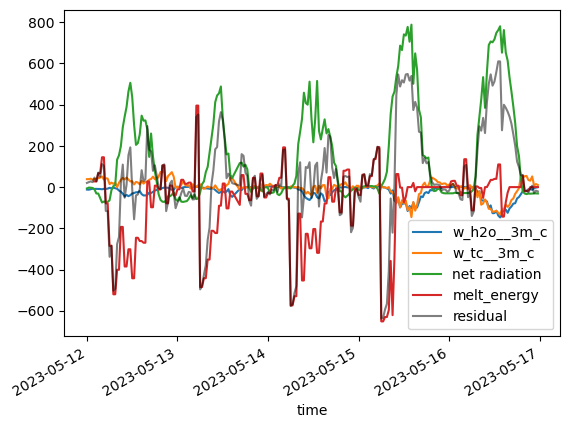

In [408]:
fig, ax = plt.subplots()
energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].loc['20230512': '20230516'].plot(ax=ax)
pd.DataFrame(energy_balance_df[[
    'w_h2o__3m_c', 'w_tc__3m_c', 'net radiation', 'melt_energy'
]].sum(axis=1).rename('residual')).loc['20230512': '20230516'].plot(color='black', alpha=0.5, ax=ax)